In [47]:
import os
import pandas as pd
import numpy as np
from  scipy.signal import correlate2d
from mpl_toolkits.axes_grid1 import make_axes_locatable

# from numpy.linalg import norm
# import matplotlib
from matplotlib import pyplot as plt

import tensorflow as tf

from clearn.utils.data_loader import load_images
from clearn.utils.utils import get_latent_vector_column, show_all_variables, get_pmf_y_given_z
from clearn.config.common_path import get_encoded_csv_file
from clearn.models.classify.classifier import ClassifierModel
from clearn.config import ExperimentConfig
from clearn.analysis.encode_decode import decode, encode, encode_and_get_features, decode_and_get_features


In [48]:
from matplotlib import pyplot  as  plt
%matplotlib inline

In [49]:
N_3 = 32
N_2 = 128
N_1 = 64
Z_DIM = 10
run_id = 3

ROOT_PATH = "/home/sunilv/concept_learning_data/"
exp_config = ExperimentConfig(ROOT_PATH,
                              4,
                              Z_DIM,
                              [N_1, N_2, N_3],
                              num_val_samples=128,
                              confidence_decay_factor=5,
                              num_cluster_config=None)

exp_config.check_and_create_directories(run_id)
BATCH_SIZE = exp_config.BATCH_SIZE
DATASET_NAME = exp_config.dataset_name


In [50]:
model = None
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        model = ClassifierModel(exp_config,
                                sess,
                                epoch=1,
                                batch_size=BATCH_SIZE,
                                z_dim=Z_DIM,
                                dataset_name=DATASET_NAME,
                                beta = exp_config.beta,
                                num_units_in_layer=exp_config.num_units,
                                log_dir=exp_config.LOG_PATH,
                                checkpoint_dir=exp_config.TRAINED_MODELS_PATH,
                                result_dir=exp_config.PREDICTION_RESULTS_PATH
                               )
        print(model.get_trainable_vars())
        num_steps_completed = model.counter
        print("Number of steps completed={}".format(num_steps_completed))
        num_batches = exp_config.num_train_samples / exp_config.BATCH_SIZE
        epochs_completed = num_steps_completed // num_batches
        print("Number of epochs completed {}".format(epochs_completed))
        encoder_params = model.get_encoder_weights_bias()
        decoder_params =model.get_decoder_weights_bias()
tf.reset_default_graph()

INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
 [*] Reading checkpoints...
ckpt_name ClassifierModel.model-4676
INFO:tensorflow:Restoring parameters from /home/sunilv/concept_learning_data/Exp_10_032_128_3/trained_models/ClassifierModel.model-4676
 [*] Success to read ClassifierModel.model-4676
 [*] Load SUCCESS
[<tf.Variable 'encoder/en_conv1/w:0' shape=(3, 3, 1, 64) dtype=float32_ref>, <tf.Variable 'encoder/en_conv1/biases:0' shape=(64,) dtype=float32_ref>, <tf.Variable 'encoder/en_conv2/w:0' shape=(3, 3, 64, 128) dtype=float32_ref>, <tf.Variable 'encoder/en_conv2/biases:0' shape=(128,) dtype=float32_ref>, <tf.Variable 'encoder/en_fc3/Matrix:0' shape=(6272, 32) dtype=float32_ref>,

In [51]:
keys = [k for  k in encoder_params]
print(keys)

['encoder/en_conv1/w:0', 'encoder/en_conv1/biases:0', 'encoder/en_conv2/w:0', 'encoder/en_conv2/biases:0', 'encoder/en_fc3/Matrix:0', 'encoder/en_fc3/bias:0', 'encoder/en_fc4/Matrix:0', 'encoder/en_fc4/bias:0']


In [52]:
weights_layer_1 = encoder_params["encoder/en_conv1/w:0"]
bias = encoder_params["encoder/en_conv1/biases:0"]

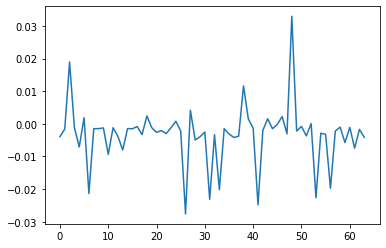

In [53]:
plt.plot(bias)

In [54]:
final_layer_wights = encoder_params["encoder/en_fc4/Matrix:0"]
final_layer_wights.shape

(32, 20)

In [55]:
final_layer_bias = encoder_params["encoder/en_fc4/bias:0"]
final_layer_bias.shape

(20,)

In [56]:
mean_weithts = final_layer_wights[:,0:10]
mean_weithts.shape

(32, 10)

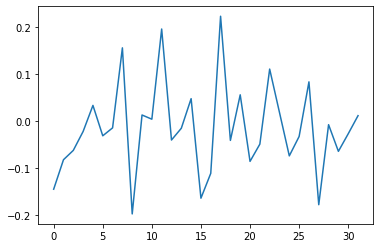

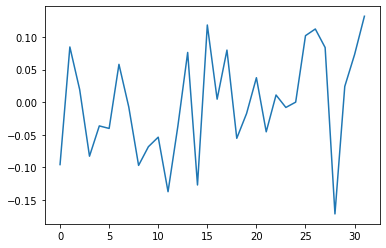

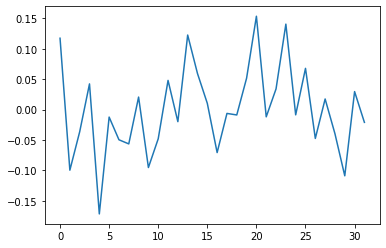

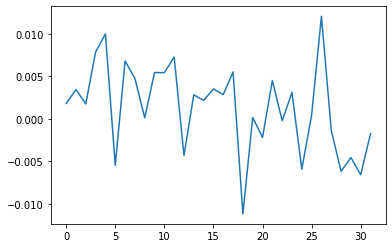

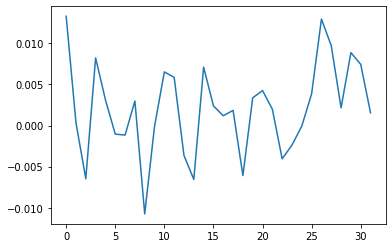

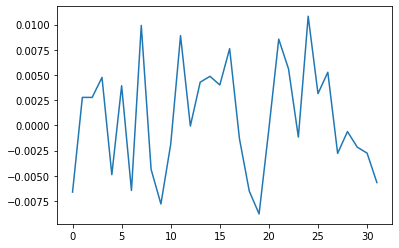

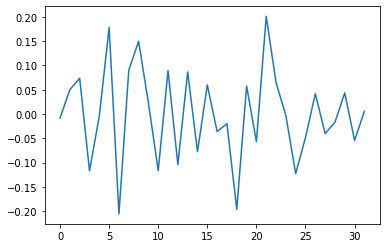

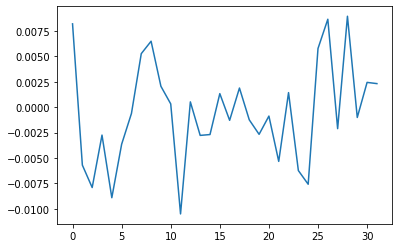

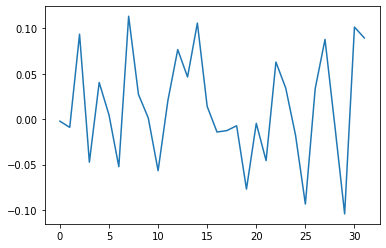

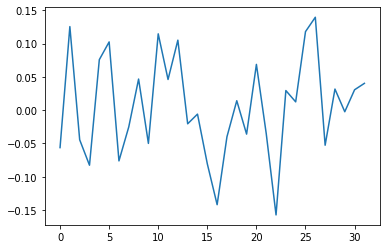

<Figure size 432x288 with 0 Axes>

In [57]:
for i in range(10):
    plt.plot(mean_weithts[:,i])
    plt.figure()


# Decode parameters

In [58]:
decoder_keys = [k for  k in decoder_params]
print(decoder_keys)

['decoder/de_fc1/Matrix:0', 'decoder/de_fc1/bias:0', 'decoder/de_dc3/w:0', 'decoder/de_dc3/biases:0', 'decoder/de_dc4/w:0', 'decoder/de_dc4/biases:0']


In [59]:
de_conv_weights = decoder_params["decoder/de_dc4/w:0"]
de_conv_bias = decoder_params["decoder/de_dc4/biases:0"]

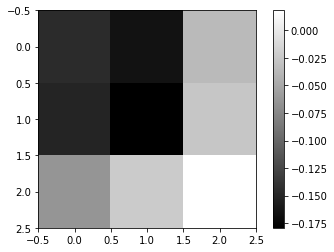

In [60]:
plt.imshow(np.squeeze(de_conv_weights[:, :, 0, 3]),cmap="gray")
plt.colorbar()

In [61]:
unused_features = []
for i in range(de_conv_weights.shape[3]):
    max_weight = np.max(np.squeeze(de_conv_weights[:, :, 0, i]))
    if max_weight <= 0.02:
        unused_features.append(i)
print(len(unused_features),unused_features)
    

28 [0, 2, 3, 8, 9, 10, 11, 12, 14, 17, 20, 21, 22, 27, 30, 32, 33, 34, 40, 42, 43, 46, 50, 52, 57, 59, 61, 63]


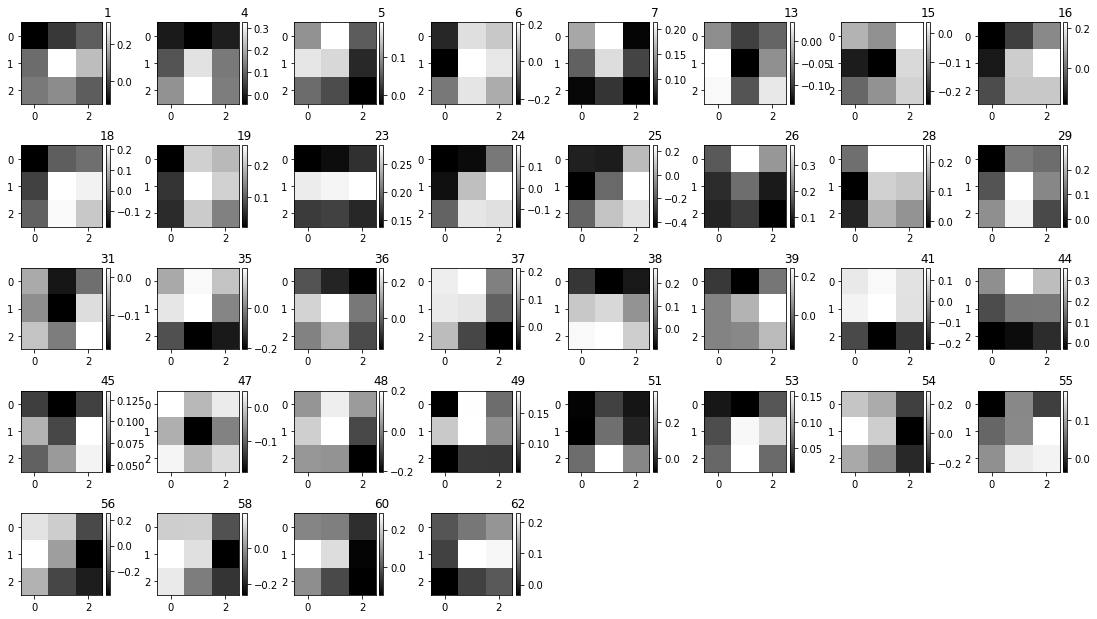

In [62]:
fig = plt.figure(figsize=(15,10))
filter_num = 0
for i in range(de_conv_weights.shape[3]):
    if  i in unused_features:
        continue
    weights = np.squeeze(de_conv_weights[:, :, 0, i])
    ax = fig.add_subplot(6, 8, filter_num + 1)
    filter_num += 1
    plt.imshow(weights, cmap="gray")
    divider = make_axes_locatable(ax)
    cax1= divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(cax=cax1)
    plt.title(str(i))
fig.tight_layout(pad=0.05)

In [63]:
filename  = get_encoded_csv_file(N_2, N_3, Z_DIM, int(epochs_completed), "train")
mean_col_names, sigma_col_names, z_col_names = get_latent_vector_column(Z_DIM)
df = pd.read_csv(os.path.join(exp_config.ANALYSIS_PATH, filename))
z_min = df[z_col_names].min().min()
z_max = df[z_col_names].max().max()
latent_vectors = df[z_col_names].values
print("run_id={} z_min={} z_max={}".format(run_id, z_min, z_max))
print("Latent vectors shape",latent_vectors.shape)

run_id=3 z_min=-4.770509 z_max=4.733666
Latent vectors shape (59840, 10)


In [64]:
manual_annotation_file = os.path.join(exp_config.ANALYSIS_PATH,
                                      "manual_annotation_epoch_{}.csv".format(epochs_completed - 1)
                                     )
train_val_iterator, images, labels, manual_annotation_np = load_images(exp_config,
                                                                    "val",
                                                                    manual_annotation_file)
unique_labels = train_val_iterator.get_unique_labels()
num_batches = images.shape[0] / exp_config.BATCH_SIZE
epochs_completed = num_steps_completed // num_batches
print("Number of epochs completed {}".format(epochs_completed))
labels= np.argwhere(labels == 1)[:,1]

Warning /home/sunilv/concept_learning_data/Exp_10_032_128_3/analysis/manual_annotation_epoch_4.0.csv path does not exist. Creating random prior with uniform distribution
Number of epochs completed 2338.0


In [65]:
from typing import List, DefaultDict
from collections import defaultdict

# Decode and encode images

In [66]:
# for im in images_0:
#     plt.imshow(np.squeeze(im),cmap="gray")
#     plt.figure()

# get the latent vectors and reconstructed images
model = None
tf.reset_default_graph()
latent_vectors = []
reconstructed_images = []
images_by_label = []
decoder_features =defaultdict(list)
encoder_features = defaultdict(list)
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        model = ClassifierModel(exp_config,
                                sess,
                                epoch=1,
                                batch_size=BATCH_SIZE,
                                z_dim=Z_DIM,
                                dataset_name=DATASET_NAME,
                                beta = exp_config.beta,
                                num_units_in_layer=exp_config.num_units,
                                log_dir=exp_config.LOG_PATH,
                                checkpoint_dir=exp_config.TRAINED_MODELS_PATH,
                                result_dir=exp_config.PREDICTION_RESULTS_PATH
                               )
        num_steps_completed = model.counter
        print("Number of steps completed={}".format(num_steps_completed))
        num_batches = exp_config.num_train_samples / exp_config.BATCH_SIZE
        epochs_completed = num_steps_completed // num_batches
        print("Number of epochs completed {}".format(epochs_completed))
        for d in range(10):
            indices = np.argwhere(labels == d)
            images_by_label.append(images[indices])
            mus, sigmas, zs, dense2_ens, reshapeds, conv2_ens, conv1_ens = encode_and_get_features(model,
                                                                                                   np.squeeze(images[indices],axis=1),
                                                                                                   exp_config.BATCH_SIZE,
                                                                                                  exp_config.Z_DIM)
            encoder_features["dense_2"].append(dense2_ens)
            latent_vectors.append(zs)
            recon_images,dense1_de, dense2_de, reshaped_de, deconv1_de = decode_and_get_features(model, latent_vectors[-1], exp_config.BATCH_SIZE)
            reconstructed_images.append( recon_images
                                       )
            decoder_features["dense_2"].append(dense2_de)
            decoder_features["dense_1"].append(dense1_de)
            decoder_features["deconv_1"].append(deconv1_de)

tf.reset_default_graph()

INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
 [*] Reading checkpoints...
ckpt_name ClassifierModel.model-4676
INFO:tensorflow:Restoring parameters from /home/sunilv/concept_learning_data/Exp_10_032_128_3/trained_models/ClassifierModel.model-4676
 [*] Success to read ClassifierModel.model-4676
 [*] Load SUCCESS
Number of steps completed=4676
Number of epochs completed 5.0


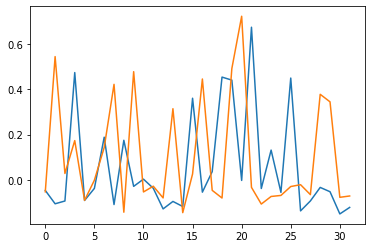

In [67]:
for d in range(1):
    num_images = len(images_by_label[d])
    features_en= encoder_features["dense_2"][d][0][0:num_images]
    features_en = features_en / np.max(features_en)
    features_de = decoder_features["dense_1"][d][0][0:num_images]
    plt.plot(features_en[0])
    plt.plot(features_de[0])


In [68]:
num_images = len(images_by_label[0])
features_de = decoder_features["deconv_1"][d][0][0:num_images]

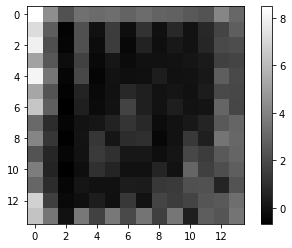

In [69]:
plt.imshow(np.squeeze(features_de[0, :, :, 3]),cmap="gray")
plt.colorbar()

In [70]:
decoder_features["dense_1"][d][0][0:num_images].shape

(13, 32)

In [71]:
def display_images(images_0):
    for im in images_0:
        plt.imshow(np.squeeze(im),cmap="gray")
        plt.figure()


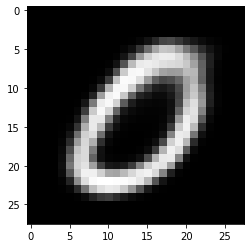

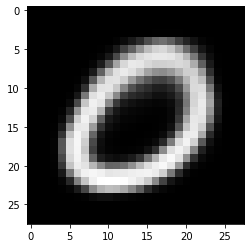

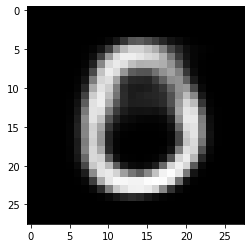

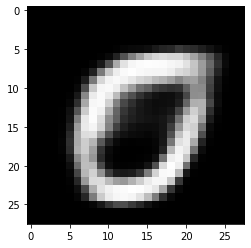

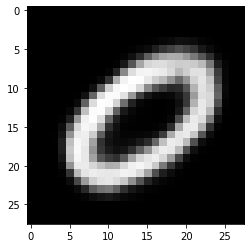

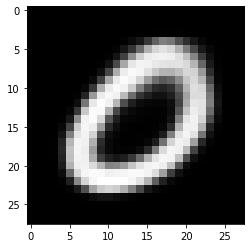

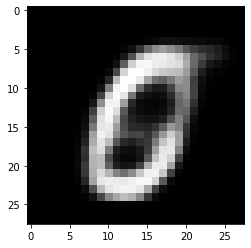

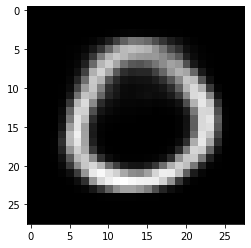

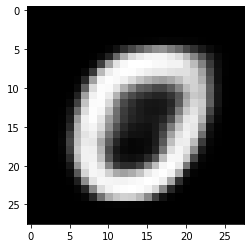

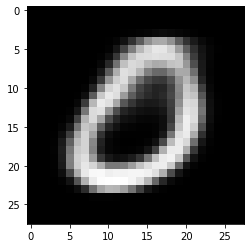

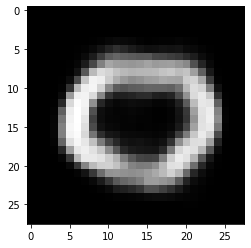

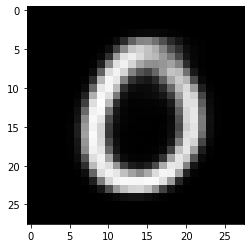

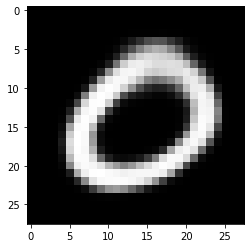

<Figure size 432x288 with 0 Axes>

In [72]:
display_images(reconstructed_images[0])

In [73]:
# for i  in range(latent_vectors.shape[0]):
#     plt.plot(latent_vectors[i])
#     plt.figure()

In [74]:
# print(reconstructed_images.shape)
# for i in range(reconstructed_images.shape[0]):
#     plt.imshow(np.squeeze(reconstructed_images[i]), cmap="gray")
#     plt.figure()

In [75]:
def trace_dim(mu, num_trace_steps,  dim):    
    z = np.zeros([num_trace_steps , Z_DIM])
    for i in range(num_trace_steps):
        z[i] = mu
    z_min =  -5
    z_max = 5
        
    step = 1 / num_trace_steps
    for i in range(num_trace_steps):
        alpha_i = step * i
        z[i, dim ] = alpha_i * z_min + (1 - alpha_i) * z_max
    return z

In [76]:
num_trace_steps = 36
tf.reset_default_graph()
reconstructed_deformed_images = []
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
    model = ClassifierModel(exp_config,
                            sess,
                            epoch=1,
                            batch_size=BATCH_SIZE,
                            z_dim=Z_DIM,
                            dataset_name=DATASET_NAME,
                            beta = exp_config.beta,
                            num_units_in_layer=exp_config.num_units,
                            log_dir=exp_config.LOG_PATH,
                            checkpoint_dir=exp_config.TRAINED_MODELS_PATH,
                            result_dir=exp_config.PREDICTION_RESULTS_PATH
                           )
    checkpoint_counter = model.load_from_checkpoint()
    print("Check point counter", checkpoint_counter)
    for d in range(len(unique_labels)):
        num_latent_vectors = 0
        total_latent_vectors =  Z_DIM * num_trace_steps
        if total_latent_vectors < BATCH_SIZE:
            total_latent_vectors = BATCH_SIZE
        z = np.zeros([total_latent_vectors, Z_DIM])
        for dimension in range(Z_DIM):
            #TODO compute this for all images with each label
            traced_from_to = trace_dim(latent_vectors[d][0], num_trace_steps, dimension)
            for i in range(num_trace_steps):
                z[num_latent_vectors, :] = traced_from_to[i]
                num_latent_vectors += 1
        reconstructed_deformed_images.append(decode(model, z, BATCH_SIZE))

INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
 [*] Reading checkpoints...
ckpt_name ClassifierModel.model-4676
INFO:tensorflow:Restoring parameters from /home/sunilv/concept_learning_data/Exp_10_032_128_3/trained_models/ClassifierModel.model-4676
 [*] Success to read ClassifierModel.model-4676
 [*] Load SUCCESS
 [*] Reading checkpoints...
ckpt_name ClassifierModel.model-4676
INFO:tensorflow:Restoring parameters from /home/sunilv/concept_learning_data/Exp_10_032_128_3/trained_models/ClassifierModel.model-4676
 [*] Success to read ClassifierModel.model-4676
 [*] Load SUCCESS
Check point counter 4676


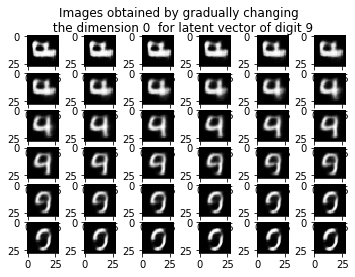

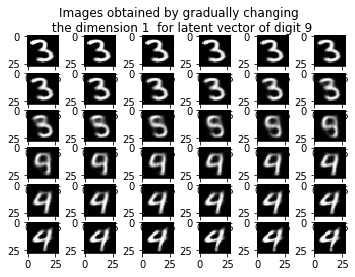

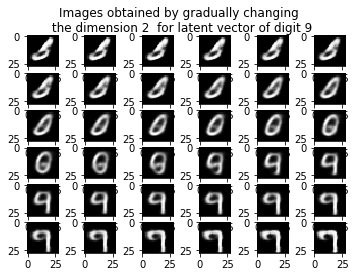

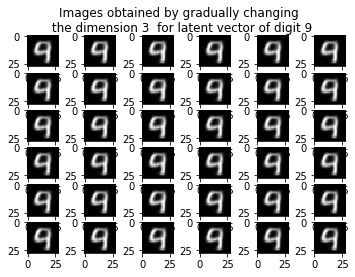

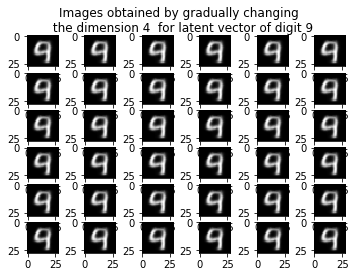

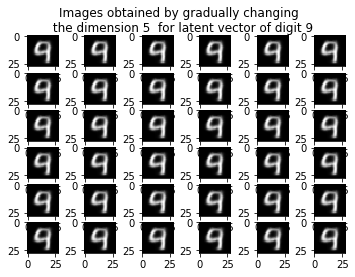

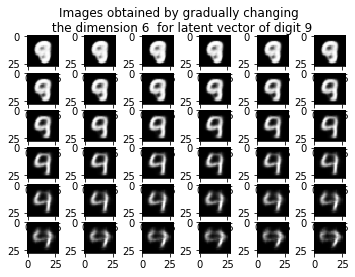

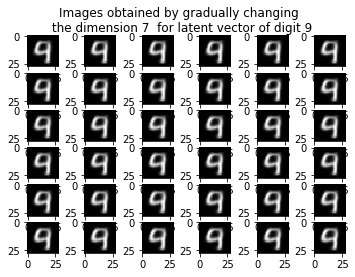

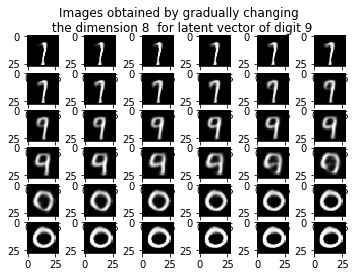

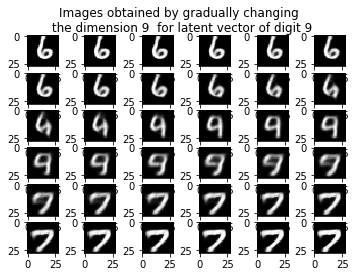

In [77]:
d = 9
title_string = "Images obtained by gradually changing \n the dimension {}  for latent vector of digit {}"
for dim in range(10):
    fig = plt.figure()
    fig.suptitle(title_string.format(dim,d))
    for i in range(num_trace_steps):
        ax = fig.add_subplot(6, 6, i + 1)
        ax.imshow(np.squeeze(reconstructed_deformed_images[d][dim * num_trace_steps + i]), cmap="gray")
    #plt.savefig(ANALYSIS_PATH+"trace_dim_{}.png".format(d))

In [78]:
sensitive_dimensions = {0:[1,2,3,5,7,8,9],
                        1:[1,2,3,5,7,8,9],
                        2:[1,2,3,5,7,8,9],
                        3:[1,2,3,5,7,8,9],
                        4:[1,2,3,5,7,8,9],
                        5:[1,2,3,5,7,8,9],
                        6:[1,2,3,5,7,8,9],
                        7:[1,2,3,5,7,8,9],
                        8:[1,2,3,5,7,8,9],
                        9:[1,2,3,5,7,8,9]
                       }

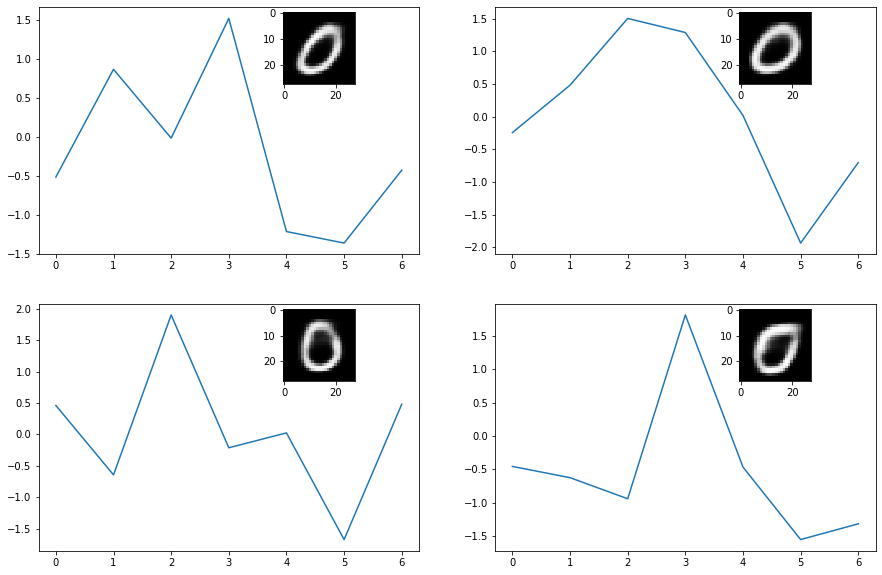

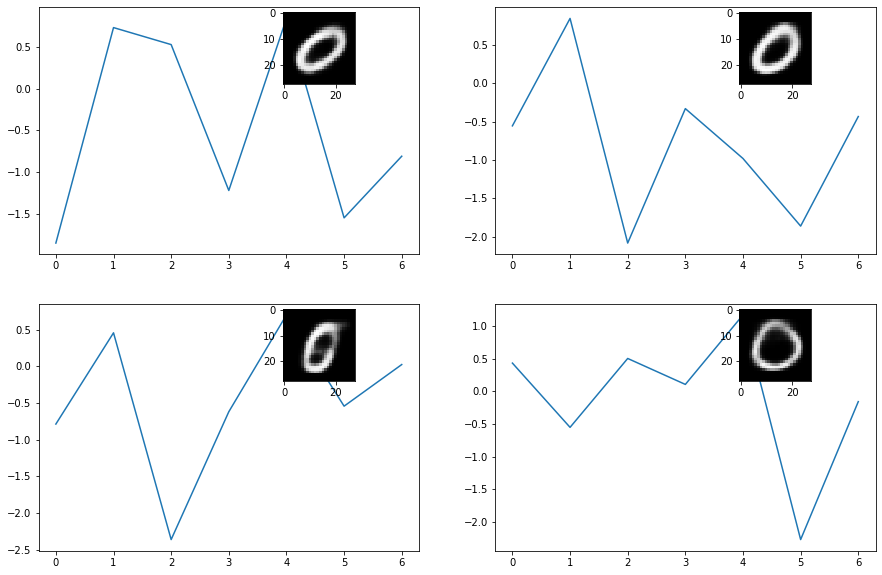

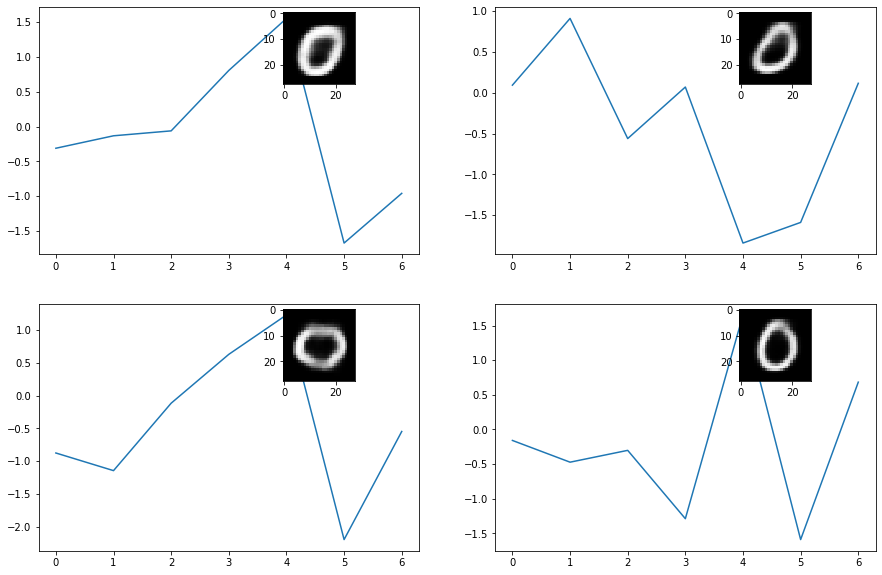

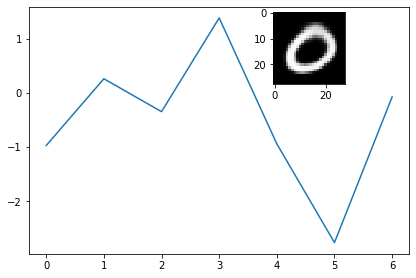

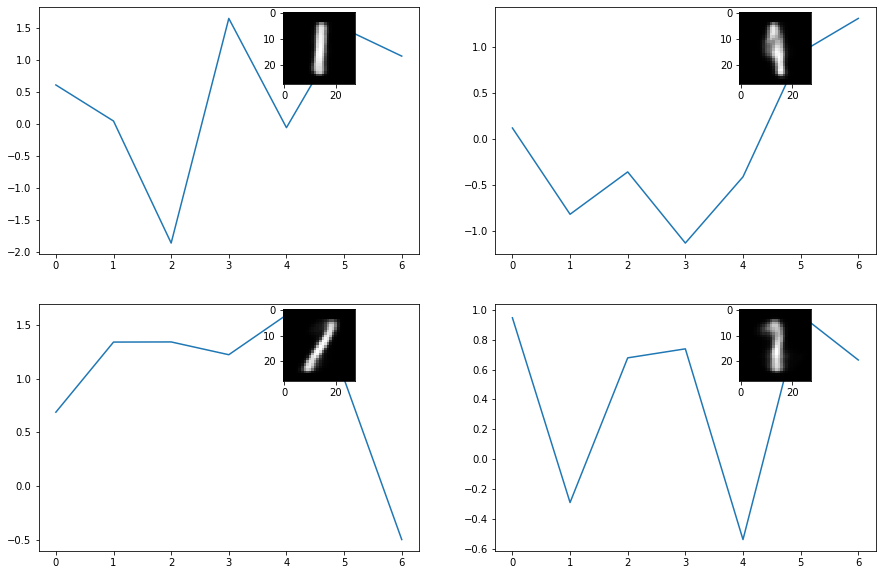

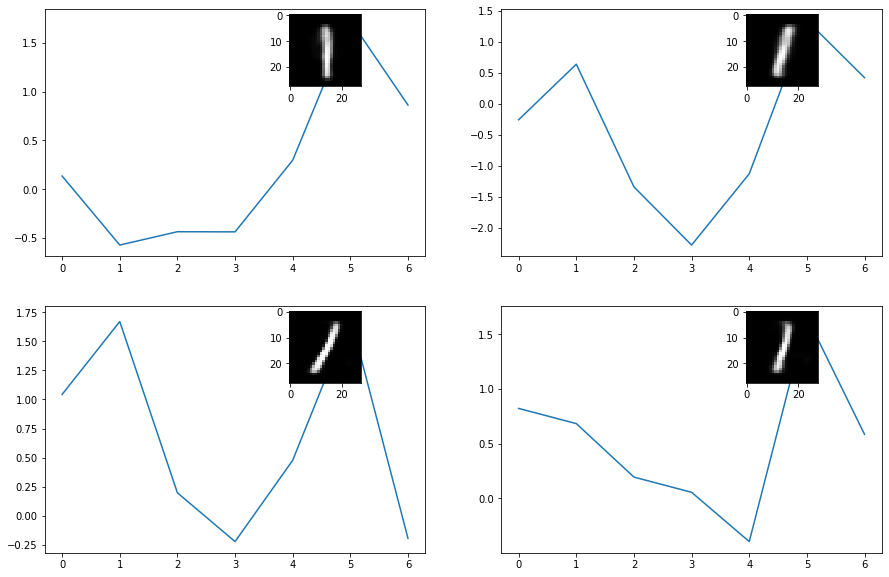

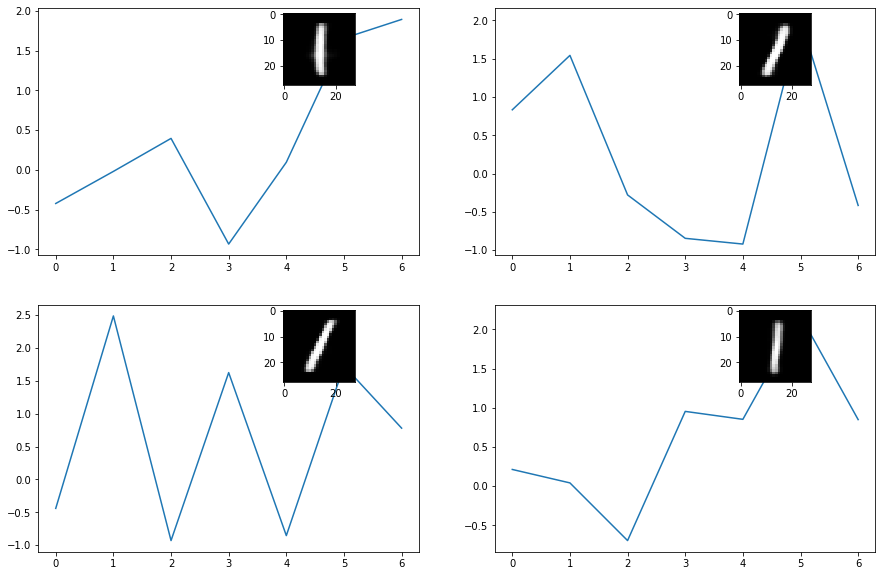

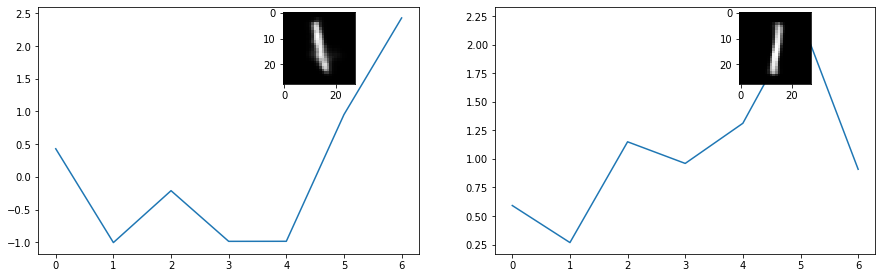

In [79]:
from mpl_toolkits.axes_grid.inset_locator import inset_axes
for d, _latent_vectors in enumerate(latent_vectors):
    if d > 1:
        continue
    
    for i in range(_latent_vectors.shape[0]):
        if i % 4 == 0:
            fig = plt.figure(figsize=(15,10))
        ax = fig.add_subplot(2, 2, i % 4 + 1)
        plt.plot(_latent_vectors[i][sensitive_dimensions[d]])
        iax = inset_axes(ax, width="50%",height=1,loc=1)

        #plt.axes([0.65, 0.65, 0.2, 0.2], facecolor='y')
        plt.imshow(np.squeeze(reconstructed_images[d][i]),cmap="gray")
        
        
        

In [80]:
from collections import defaultdict
sensitive_dimensions_all_labels =[]
sensitive_dimensions = defaultdict(list)

for d in range(len(unique_labels)):
    _reconstructed_deformed_images = reconstructed_deformed_images[d]
    for dim in range(Z_DIM):
        distances = []
        for step_num in range(num_trace_steps):
            distances.append(np.linalg.norm(np.squeeze(reconstructed_images[d][0]) - np.squeeze(_reconstructed_deformed_images[num_trace_steps * dim + step_num]) ))
        max_distance = max(distances)
        #print("Dimension {} Senssitivity {}".format(dim,max_distance))

        if max_distance > 10:
            sensitive_dimensions[d].append(dim)
    #sensitive_dimensions_all_labels.append(sensitive_dimensions)
    

In [81]:
sensitive_dimensions

defaultdict(list,
            {0: [0, 2],
             1: [8],
             2: [2, 8],
             3: [8],
             4: [8],
             5: [2, 8],
             6: [1],
             7: [8],
             8: [2, 8],
             9: [1, 8]})

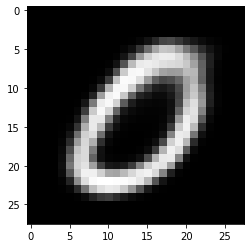

In [82]:
plt.imshow(np.squeeze(reconstructed_images[0][0] ),cmap="gray")

In [83]:
_reconstructed_deformed_images = reconstructed_deformed_images[0]

In [84]:
# sensitive_dimensions = defaultdict(list)
# d= 0
# _reconstructed_deformed_images = reconstructed_deformed_images[d]
# for dim in range(Z_DIM):
#     distances = []
#     for step_num in range(num_trace_steps):
#         deformed = np.squeeze(_reconstructed_deformed_images[num_trace_steps * dim + step_num])
#         plt.imshow(deformed,cmap="gray")
#         distance = np.linalg.norm(np.squeeze(reconstructed_images[d][0]) - deformed )
#         plt.title(f"{dim}_{num_trace_steps * dim + step_num}_{distance}")
#         plt.figure()
#         distances.append(distance)
#     max_distance = max(distances)
#     print("Dimension {} Senssitivity {}".format(dim,max_distance))

#     if max_distance > 10:
#         sensitive_dimensions[d].append(dim)

In [86]:
def insert_zeros(r,s):
    zero_inserted = np.zeros((s + 1) * r.shape[0])
    for i in range(r.shape[0]):
        zero_inserted[(s + 1) * i] = r[i]
    return zero_inserted

In [87]:
def deconv(a, k, stride):
    result_1 = np.zeros(tuple([stride * s for s in a.shape]))
    for  i  in range(a.shape[0]):
        ai_zero_inserted = insert_zeros(a[i], stride- 1)
        result_1[stride * i,:] = ai_zero_inserted
    return correlate2d(result_1, k)

# Find significant filters

In [41]:
def plot_output(out, threshold, fig_title=None):
    out_sigmoid = 1/(1 + np.exp(-out ))

    fig = plt.figure(figsize=(10,10))
    ax =  fig.add_subplot(2,2,1)
    plt.imshow(out, cmap="gray")
    divider = make_axes_locatable(ax)
    cax1 = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(cax=cax1)
    ax.set_title("Out")

    thresholded = np.zeros_like(out)
    thresholded[out > threshold] = 1
    ax = fig.add_subplot(2,2,2)
    plt.imshow(thresholded, cmap="gray")
    cax1 = make_axes_locatable(ax).append_axes("right", size="5%", pad=0.05)
    plt.colorbar(cax=cax1)
    ax.set_title(f"Thresholded at {threshold}")

    ax = fig.add_subplot(2,2,3)
    plt.imshow(out_sigmoid, cmap="gray")
    cax1 = make_axes_locatable(ax).append_axes("right", size="5%", pad=0.05)
    plt.colorbar(cax=cax1)
    ax.set_title("Sigmoid Output")
    
    if fig_title is not None:
        fig.suptitle(fig_title)

Text(0.5, 1.0, 'Sigmoid Output')

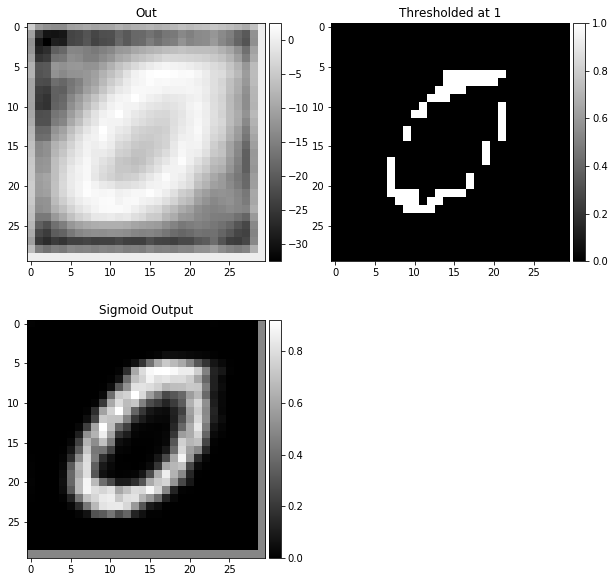

In [88]:
h = features_de[0][:,:,i].shape[0]
w = features_de[0][:,:,i].shape[1]
stride = 2
padding = 1
num_filters = de_conv_weights.shape[3]
threshold = 1

deconvolved = np.zeros([stride * h + 2 * padding, stride * w + 2 * padding])
delta_by_filter = np.zeros(num_filters)
feature_maps = []
for i in range(num_filters):
    feature_map = deconv(features_de[0][:,:,i], de_conv_weights[:, :, 0, i], 2)
    deconvolved += feature_map
    feature_maps.append(feature_map)
out = deconvolved + de_conv_bias
#plot_output(out, 1)
out_sigmoid = 1/(1 + np.exp(-out ))

fig = plt.figure(figsize=(10,10))
ax =  fig.add_subplot(2,2,1)
plt.imshow(out, cmap="gray")
divider = make_axes_locatable(ax)
cax1 = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(cax=cax1)
ax.set_title("Out")

thresholded = np.zeros_like(out)
thresholded[out > threshold] = 1
ax = fig.add_subplot(2,2,2)
plt.imshow(thresholded, cmap="gray")
cax1 = make_axes_locatable(ax).append_axes("right", size="5%", pad=0.05)
plt.colorbar(cax=cax1)
ax.set_title(f"Thresholded at {threshold}")

ax = fig.add_subplot(2,2,3)
plt.imshow(out_sigmoid, cmap="gray")
cax1 = make_axes_locatable(ax).append_axes("right", size="5%", pad=0.05)
plt.colorbar(cax=cax1)
ax.set_title("Sigmoid Output")

# if fig_title is not None:
#     fig.suptitle(fig_title)

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  2.,  1.,  1.,  0.,  1.,
         0.,  1.,  0.,  0.,  1.,  1.,  1.,  2.,  2.,  2.,  6.,  4.,  7.,
         5.,  5.,  6.,  3.,  4.,  3.,  5.,  5.,  4.,  3.,  2.,  7.,  2.,
         5., 12.,  7.,  3.,  4.,  6.,  4.,  6.,  9., 11., 15., 13.,  9.,
        20., 12., 14., 11., 15., 14., 13., 13., 10.,  9., 13., 12., 10.,
         9.,  7., 13., 14.,  8., 11.,  9.,  8., 15., 16., 16., 10.,  9.,
        10., 15., 13., 12., 11., 13., 17.,  9., 14., 16., 13., 13., 20.,
        18., 77., 17., 28., 25., 26., 14.,  8.,  8.]),
 array([-3.25368779e+01, -3.21867963e+01, -3.18367146e+01, -3.14866329e+01,
        -3.11365513e+01, -3.07864696e+01, -3.04363880e+01, -3.00863063e+01,
        -2.97362247e+01, -2.93861430e+01, -2.90360614e+01, -2.86859797e+01,
        -2.83358980e+01, -2.79858164e+01, -2.76357347e+01, -2.72856531e+01,
        -2.69355714e+01, -2.65854898e+01, -2.62354081e+01, -2.58853265e+01,
        -2.55352448e+01, -2.51851632e+01, -2.48350815e

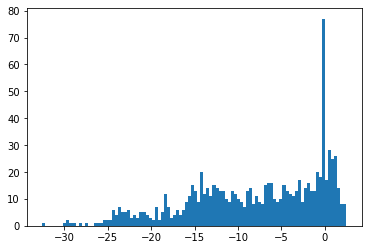

In [89]:
plt.hist(np.ravel(out),bins=100)

In [43]:
num_filters

64

# Plot individual featuremaps

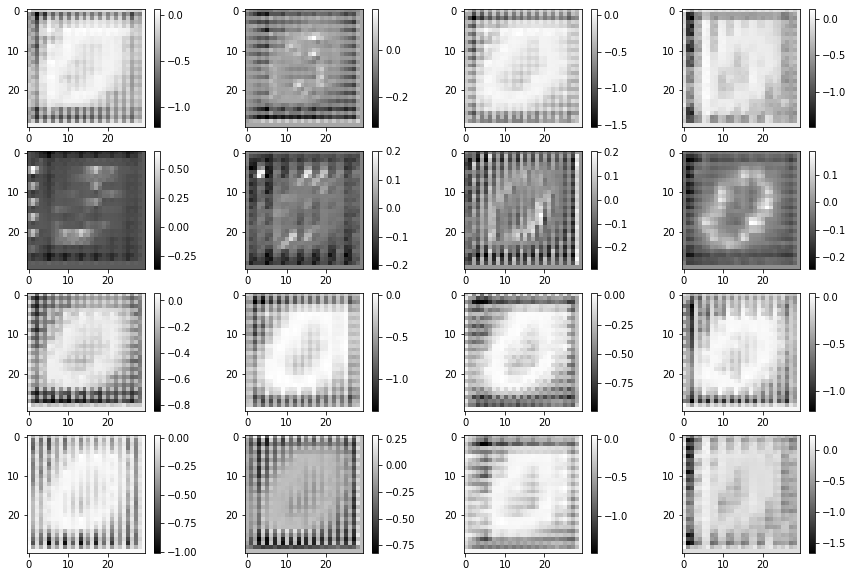

In [105]:

fig = plt.figure(figsize=(15,10))
for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1)
    plt.imshow(feature_maps[i],cmap="gray")
    plt.colorbar()

In [106]:
num_significant_filters = 20

filter_correlations = np.zeros(num_filters)
for filter_num in range(num_filters):
    m = np.corrcoef(feature_maps[filter_num].flat, out.flat)
    filter_correlations[filter_num] = m[0,1]
    
index_array = np.argsort(filter_correlations)
significant_filters = index_array[(num_filters- num_significant_filters):]
insignificant_filters = index_array[:(num_filters- num_significant_filters)]
print(significant_filters)

[40 11 17 53 22  8  2 20  0 42 43 33  9  7 46 30 10 27 50 21]


In [107]:
index_array

array([25, 56, 24, 16, 58, 60, 45, 47, 36, 51, 35, 41, 26, 54, 39, 18,  6,
       48,  4, 23, 44, 38, 13,  1, 37, 15, 19, 12, 52, 28, 57, 55, 31,  5,
       49, 61, 34, 62, 63, 14, 59, 32,  3, 29, 40, 11, 17, 53, 22,  8,  2,
       20,  0, 42, 43, 33,  9,  7, 46, 30, 10, 27, 50, 21])

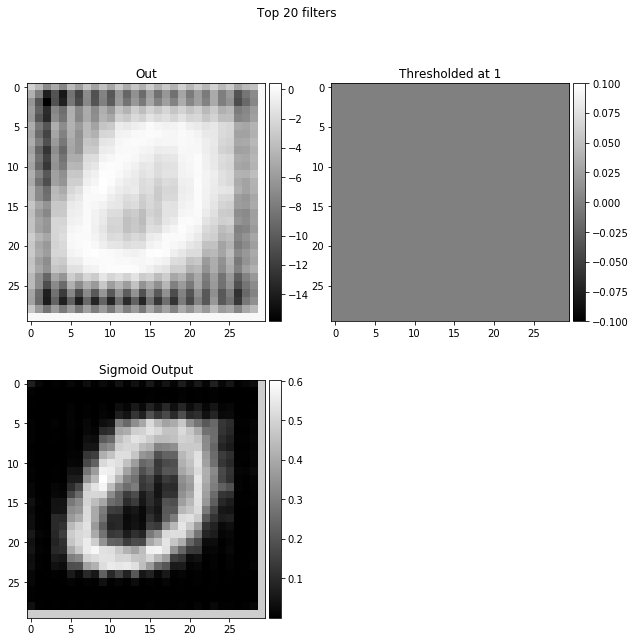

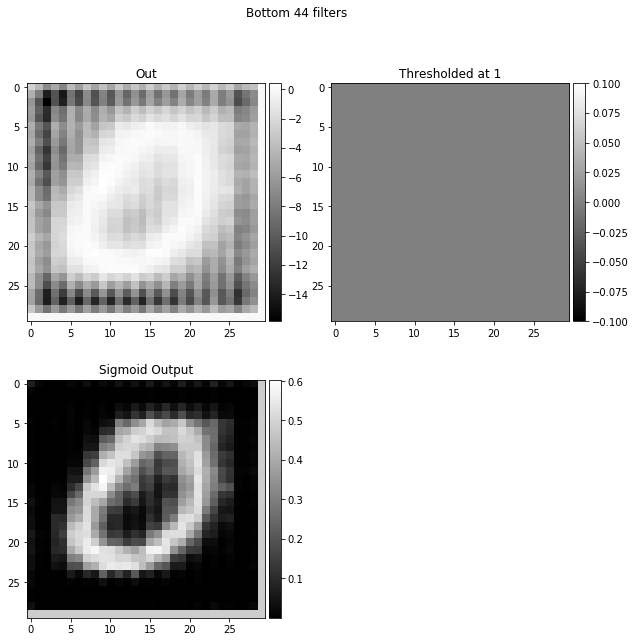

In [108]:
deconvolved = np.zeros([stride * h + 2 * padding, stride * w + 2 * padding])
delta_by_filter = np.zeros(num_filters)
feature_maps = []
for i in range(num_filters):
    if i  in insignificant_filters:
        continue
    feature_map = deconv(features_de[0][:,:,i], de_conv_weights[:, :, 0, i], 2)
    deconvolved += feature_map
    feature_maps.append(feature_map)
out = deconvolved + de_conv_bias
plot_output(out,1,"Top "+str(num_significant_filters)+" filters")


deconvolved = np.zeros([stride * h + 2 * padding, stride * w + 2 * padding])
delta_by_filter = np.zeros(num_filters)
feature_maps = []
for i in range(num_filters):
    if i  in significant_filters:
        continue
    feature_map = deconv(features_de[0][:,:,i], de_conv_weights[:, :, 0, i], 2)
    deconvolved += feature_map
    feature_maps.append(feature_map)
plot_output(out,1,"Bottom "+str(num_filters - num_significant_filters)+" filters")

(array([536.,  11.,  12.,  10.,   8.,   4.,   4.,   6.,   3.,   3.,   4.,
          4.,   2.,   5.,   3.,   3.,   1.,   1.,   2.,   4.,   4.,   1.,
          2.,   1.,   2.,   2.,   0.,   1.,   3.,   1.,   4.,   0.,   2.,
          2.,   1.,   0.,   1.,   4.,   2.,   1.,   3.,   3.,   0.,   4.,
          2.,   3.,   2.,   2.,   0.,  59.,   3.,   1.,   2.,   1.,   0.,
          2.,   1.,   1.,   1.,   3.,   1.,   0.,   1.,   1.,   2.,   5.,
          2.,   3.,   1.,   1.,   2.,   3.,   0.,   6.,   2.,   1.,   5.,
          2.,   6.,   2.,   4.,   3.,   6.,   2.,   8.,   5.,   5.,   8.,
          4.,   4.,   5.,   4.,   3.,   3.,   9.,   6.,   3.,   8.,   5.,
          6.]),
 array([6.75489071e-17, 9.68927303e-03, 1.93785461e-02, 2.90678191e-02,
        3.87570921e-02, 4.84463652e-02, 5.81356382e-02, 6.78249112e-02,
        7.75141843e-02, 8.72034573e-02, 9.68927303e-02, 1.06582003e-01,
        1.16271276e-01, 1.25960549e-01, 1.35649822e-01, 1.45339096e-01,
        1.55028369e-01, 1.6471

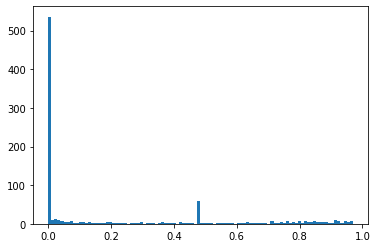

In [78]:
plt.hist(np.ravel(out),bins=100)

In [135]:
fg_indices = np.where(out > 0)
for x, y in zip(fg_indices[0], fg_indices[1]):
    print(out[x,y])

0.5953834009072241
1.1017657098440914
1.038992785767155
0.7935240516167019
0.15104541499981528
0.5281652039557048
1.3953792582773659
2.122495786483831
2.3957140745134033
2.530252461900137
2.334179138317815
1.9614583424489935
1.94614856172022
1.5641828932178286
0.020678674111693607
0.9629848101907335
1.3735698980328883
2.1841541315168076
1.6349384377123062
1.8462395414146888
1.6049315512807276
1.665508102351848
1.5064079546725135
1.2203392942356046
0.20941020558034962
0.7401898021707366
1.692340038879449
1.823221760225123
1.792181549478082
1.486602719634995
1.1125862034655751
1.1061436777591063
0.9650338467081228
1.5253390809062364
1.7846654849032637
0.6935447833031214
0.43666567358511266
1.480880868367078
1.599047245426915
2.5692193951294917
1.5687041539029647
0.7443186373517345
0.13846393542412128
0.9644139502423452
1.3865716344518284
0.6594278818845221
1.292930438846276
1.7028027851248764
1.1711723865349801
1.2475175469997453
0.12922201077420997
1.1418856376675905
1.8000218551921985


In [134]:
a = np.asarray([[1,4,5,10],[2,1,5,23],[1,2,20,14]])
print(a)
print(np.where(a != 1 ))

[[ 1  4  5 10]
 [ 2  1  5 23]
 [ 1  2 20 14]]
(array([0, 0, 0, 1, 1, 1, 2, 2, 2]), array([1, 2, 3, 0, 2, 3, 1, 2, 3]))


In [102]:
deconvolved + de_conv_bias

array([[-4.52993616e+00, -1.09747417e+01, -1.27248600e+01,
        -1.41800365e+01, -1.39559592e+01, -1.19269197e+01,
        -1.13244330e+01, -1.00846972e+01, -1.02706373e+01,
        -1.00782986e+01, -1.01964687e+01, -1.00322920e+01,
        -1.07314995e+01, -1.08585188e+01, -1.09235651e+01,
        -1.03323278e+01, -1.13272253e+01, -1.14258832e+01,
        -1.13164672e+01, -1.02581629e+01, -1.09445326e+01,
        -1.04860960e+01, -1.07244219e+01, -1.04751749e+01,
        -1.05585328e+01, -9.94133658e+00, -9.98646247e+00,
        -9.43544615e+00, -6.36258902e+00, -6.33433536e-02],
       [-1.02875222e+01, -2.45289485e+01, -3.06880000e+01,
        -3.23669368e+01, -3.24441372e+01, -2.73434831e+01,
        -2.61661966e+01, -2.30347464e+01, -2.41443863e+01,
        -2.31637478e+01, -2.36286776e+01, -2.25743266e+01,
        -2.45013943e+01, -2.44730260e+01, -2.51622172e+01,
        -2.33593842e+01, -2.58395537e+01, -2.53935436e+01,
        -2.55284296e+01, -2.28301454e+01, -2.45290861e+

In [95]:
h = features_de[0][:,:,i].shape[0]
w = features_de[0][:,:,i].shape[1]
stride = 2

(14, 14)

In [101]:
de_conv_bias

array([-0.06334335], dtype=float32)

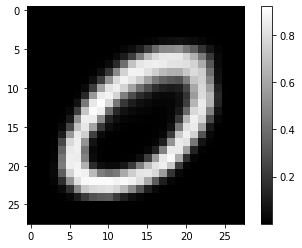

In [111]:
plt.imshow(np.squeeze(reconstructed_images[0][0]), cmap="gray")
plt.colorbar()

In [45]:
def deconv2d(w, biases, input_, output_shape, k_h=5, k_w=5, d_h=2, d_w=2, name="deconv2d", stddev=0.02, with_w=False):
    print("outputshape", output_shape)
    print("stride",[1, d_h, d_w, 1])
    deconv = tf.nn.conv2d_transpose(input_,
                                    w,
                                    output_shape=output_shape,
                                    strides=[1, d_h, d_w, 1],
                                    padding="SAME"
                                   )
    deconv = tf.reshape(tf.nn.bias_add(deconv, biases), deconv.get_shape())
    return deconv

In [46]:
#deconv1_de = features_de
deconv1_de=decoder_features["deconv_1"][d][0]

In [47]:
out = tf.nn.sigmoid(deconv2d(de_conv_weights, de_conv_bias, deconv1_de, [64, 28, 28, 1], 3, 3, 2, 2, name='de_dc4'))

outputshape [64, 28, 28, 1]
stride [1, 2, 2, 1]


In [48]:
deconv1_de.shape

(64, 14, 14, 64)

In [49]:
de_conv_weights.shape

(3, 3, 1, 64)

In [50]:
de_conv_bias.shape

(1,)

In [51]:
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
    de_conv_weights_tensor = tf.placeholder(tf.float32,[3, 3, 1, 64],name="weights")
    deconv1_de_tensor = tf.placeholder(tf.float32,[64,14, 14, 64], name="input")
    de_conv_bias_tensor = tf.placeholder(tf.float32,[1,],name="bias")
    out = tf.nn.sigmoid(deconv2d(de_conv_weights_tensor,
                                 de_conv_bias_tensor,
                                 deconv1_de_tensor,
                                 [64, 28, 28, 1],
                                 3, 3, 2, 2, name='de_dc4'
                                )
                       )
    reconstructed = sess.run(out,feed_dict={de_conv_weights_tensor:de_conv_weights,
                                            de_conv_bias_tensor:de_conv_bias,
                                            deconv1_de_tensor:deconv1_de
                                           })

outputshape [64, 28, 28, 1]
stride [1, 2, 2, 1]


In [60]:
deconv1_de.shape

(64, 14, 14, 64)

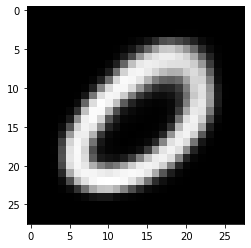

In [52]:
plt.imshow(np.squeeze(reconstructed[0,:,:,:]),cmap="gray")

In [99]:
reconstructed.shape

AttributeError: 'list' object has no attribute 'shape'

In [8]:
print([k for k  in decoder_params.keys()])

['decoder/de_fc1/Matrix:0', 'decoder/de_fc1/bias:0', 'decoder/de_dc3/w:0', 'decoder/de_dc3/biases:0', 'decoder/de_dc4/w:0', 'decoder/de_dc4/biases:0']


In [50]:
decoder_fc1_weights = decoder_params['decoder/de_fc1/Matrix:0']
decoder_fc1_bias = decoder_params['decoder/de_fc1/bias:0']

In [52]:
np.matmul(latent_vectors[0][0],decoder_fc1_weights) + decoder_fc1_bias

array([-0.48331131,  0.6284509 ,  0.06610469,  0.35841292, -0.54663376,
        0.02880641,  0.05597543,  0.44728134, -0.80991872,  0.35932851,
       -0.2813393 , -0.13534893, -0.42726249,  0.09138524, -0.84371702,
       -0.15613727,  0.43092195, -0.06991478, -0.42282355,  0.55480057,
        0.89017816, -0.2576408 , -0.61121947, -0.49408752, -0.23925049,
       -0.261613  , -0.20340326, -0.05848704,  0.33641685,  0.38695204,
       -0.59279881, -0.4963051 ])

In [53]:
decoder_features["dense_1"][0][0][0]

array([-0.02197864,  0.00448158,  0.56860185,  0.06350012, -0.09067475,
       -0.07325939,  0.168631  ,  0.16063735,  0.30728164,  0.25712156,
       -0.08140552,  0.32621178,  0.14047512, -0.01074356, -0.00404986,
        0.16588455,  0.00919943,  0.6069579 ,  0.06588379, -0.04763731,
       -0.02904688, -0.01666207,  0.2521348 , -0.03334732,  0.02106984,
        0.1194911 , -0.04501981,  0.01106588,  0.10376309,  0.4300803 ,
        0.11758616, -0.05354938], dtype=float32)

In [51]:
decoder_fc1_bias

array([-0.05514792,  0.00650364,  0.06831419,  0.02708952, -0.05018955,
       -0.05606639,  0.02932058,  0.0273481 , -0.02850756,  0.17368324,
       -0.07666606, -0.00043632,  0.04830211,  0.08243585, -0.05927725,
        0.14711487,  0.11142565,  0.10938153, -0.01367014,  0.03243916,
        0.01102042, -0.04728931,  0.07699784,  0.03866464,  0.0447809 ,
        0.14912358, -0.04392975, -0.03820319,  0.07369149,  0.1445335 ,
        0.01075074, -0.05314016], dtype=float32)

In [1]:
import os
import pandas as pd
import numpy as np
# from numpy.linalg import norm

# import matplotlib
from matplotlib import pyplot as plt

import tensorflow as tf

from clearn.utils.data_loader import load_images
from clearn.utils.utils import get_latent_vector_column, show_all_variables, get_pmf_y_given_z
from clearn.config.common_path import get_encoded_csv_file
from clearn.models.classify.classifier import ClassifierModel
from clearn.config import ExperimentConfig
from clearn.analysis.encode_decode import decode, encode, encode_and_get_features, decode_and_get_features,decode_layer1

from matplotlib import pyplot  as  plt
%matplotlib inline

N_3 = 32
N_2 = 128
N_1 = 64
Z_DIM = 10
run_id = 3

ROOT_PATH = "/home/sunilv/concept_learning_data/"
exp_config = ExperimentConfig(ROOT_PATH,
                              4,
                              Z_DIM,
                              [N_1, N_2, N_3],
                              num_val_samples=128,
                              confidence_decay_factor=5,
                              num_cluster_config=None)

exp_config.check_and_create_directories(run_id)
BATCH_SIZE = exp_config.BATCH_SIZE
DATASET_NAME = exp_config.dataset_name


exp_config.TRAINED_MODELS_PATH


/home/sunilv/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sunilv/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sunilv/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sunilv/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: 

'/home/sunilv/concept_learning_data/Exp_10_032_128_3/trained_models/'

In [2]:
z = np.zeros([64,10])

In [3]:
model = None
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        model = ClassifierModel(exp_config,
                                sess,
                                epoch=1,
                                batch_size=BATCH_SIZE,
                                z_dim=Z_DIM,
                                dataset_name=DATASET_NAME,
                                beta = exp_config.beta,
                                num_units_in_layer=exp_config.num_units,
                                log_dir=exp_config.LOG_PATH,
                                checkpoint_dir=exp_config.TRAINED_MODELS_PATH,
                                result_dir=exp_config.PREDICTION_RESULTS_PATH
                               )
        num_steps_completed = model.counter
        print("Number of steps completed={}".format(num_steps_completed))
        num_batches = exp_config.num_train_samples / exp_config.BATCH_SIZE
        epochs_completed = num_steps_completed // num_batches
        print("Number of epochs completed {}".format(epochs_completed))
        dense1_de = decode_layer1(model,z,64)
        #recon_images,dense1_de, dense2_de, reshaped_de, deconv1_de = decode_and_get_features(model, z, exp_config.BATCH_SIZE)
tf.reset_default_graph()
N_3 = 32
N_2 = 128
N_1 = 64
Z_DIM = 10
run_id = 3

ROOT_PATH = "/home/sunilv/concept_learning_data/"
exp_config = ExperimentConfig(ROOT_PATH,
                              4,
                              Z_DIM,
                              [N_1, N_2, N_3],
                              num_val_samples=128,
                              confidence_decay_factor=5,
                              num_cluster_config=None)

exp_config.check_and_create_directories(run_id)
BATCH_SIZE = exp_config.BATCH_SIZE
DATASET_NAME = exp_config.dataset_name







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.



 [*] Reading checkpoints...
ckpt_name ClassifierModel.model-4676
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /home/sunilv/concept_learning_data/Exp_10_032_128_3/trained_models/ClassifierModel.model-4676
 [*] Success to read ClassifierModel.model-4676
 [*] Load SUCCESS
Number of steps completed=4676
Number of epochs completed 5.0
